In [ ]:
!gdown --id 1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU
From (redirected): https://drive.google.com/uc?id=1BZ0MUIu47u_J3Y4NDUU-5ZxVD1ZtvWzU&confirm=t&uuid=88561f61-54ed-41b7-8d2f-82e260b517b5
To: /content/Saved Split resized 500x500.zip
100% 291M/291M [00:06<00:00, 43.6MB/s]


In [ ]:
!unzip '/content/Saved Split resized 500x500.zip' -d '/content/Saved Split resized 500x500'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_4_56_2280.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_0_43_217.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_37_1187.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_0_67_336.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_73_1367.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_2_62_1310.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_1_81_908.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_1_80_901.JPG  
  inflating: /content/Saved Split resized 500x500/New folder/train/Insect/augmented_4_1_2006.JPG  
  inflating: /content/Saved Split resized 500x500/New 

In [ ]:
!ls '/content/Saved Split resized 500x500'

'New folder'


In [ ]:
base_dir = '/content/Saved Split resized 500x500/New folder' # Replace with the correct directory name

In [ ]:
!pip install -q tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
train_dir = '/content/Saved Split resized 500x500/New folder/train'
val_dir = '/content/Saved Split resized 500x500/New folder/val'
test_dir = '/content/Saved Split resized 500x500/New folder/test'


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE, class_mode='categorical')
valid_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMAGE_SIZE,
                                                       batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMAGE_SIZE,
                                                      batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 9354 images belonging to 4 classes.
Found 1169 images belonging to 4 classes.
Found 1171 images belonging to 4 classes.


#VGG19

In [ ]:
# In cell 8
with tf.distribute.get_strategy().scope():
    input_shape = (224, 224, 3)
    # num_classes = 38 # The original value was 38 which was incorrect.
    num_classes = train_generator.num_classes # Get num_classes dynamically from generator

    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_VGG = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_VGG.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model_VGG.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,04

 Total params: 33,038,276 (126.03 MB)

 Trainable params: 13,012,100 (49.64 MB)

 Non-trainable params: 20,026,176 (76.39 MB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_VGG.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 194s 599ms/step - accuracy: 0.4191 - loss: 1.7248 - precision: 0.4399 - recall: 0.3619 - val_accuracy: 0.6527 - val_loss: 0.8877 - val_precision: 0.7134 - val_recall: 0.5834
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 160s 546ms/step - accuracy: 0.5582 - loss: 1.2734 - precision: 0.5922 - recall: 0.5130 - val_accuracy: 0.7126 - val_loss: 0.8077 - val_precision: 0.7580 - val_recall: 0.6698
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 158s 539ms/step - accuracy: 0.6062 - loss: 1.1113 - precision: 0.6456 - recall: 0.5568 - val_accuracy: 0.7203 - val_loss: 0.7858 - val_precision: 0.7617 - val_recall: 0.6809
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 156s 531ms/step - accuracy: 0.6208 - loss: 1.0721 - precision: 0.6554 - recall: 0.5696 - val_accuracy: 0.7425 - val_loss: 0.7156 - val_precision: 0.7793 - val_recall: 0.6946
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 199s 522ms/step - accuracy: 0.6376 - loss: 0.9919 - precision: 0.6773 - recall: 0.5956 - val_accuracy: 0

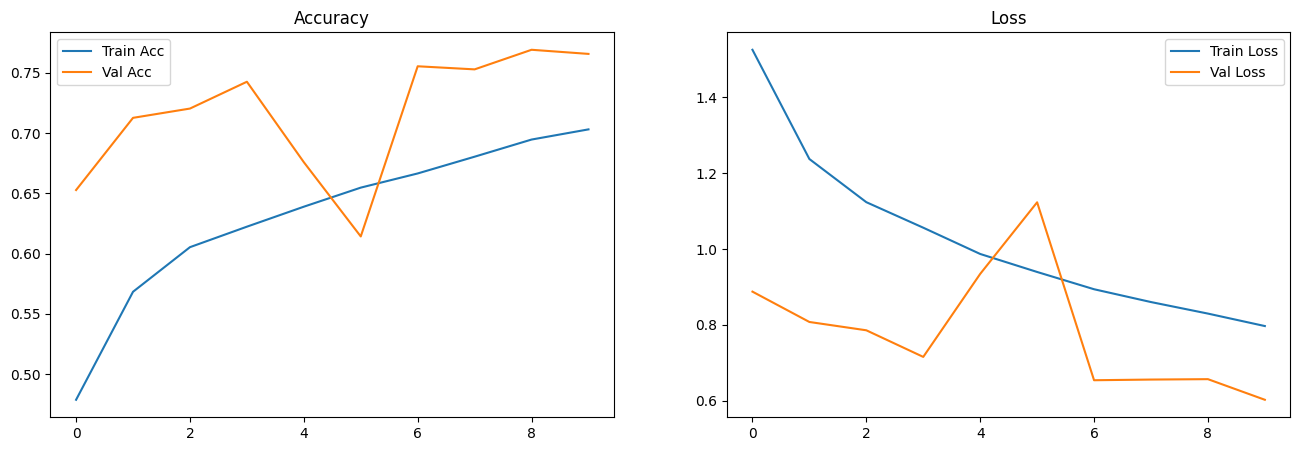

In [ ]:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history)


In [ ]:
predictions = model_VGG.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step
Classification Report:

              precision    recall  f1-score   support

       Algal       0.85      0.90      0.88       299
       Fresh       0.89      0.78      0.83       280
      Insect       0.92      0.81      0.86       298
      powder       0.77      0.90      0.83       294

    accuracy                           0.85      1171
   macro avg       0.86      0.85      0.85      1171
weighted avg       0.86      0.85      0.85      1171



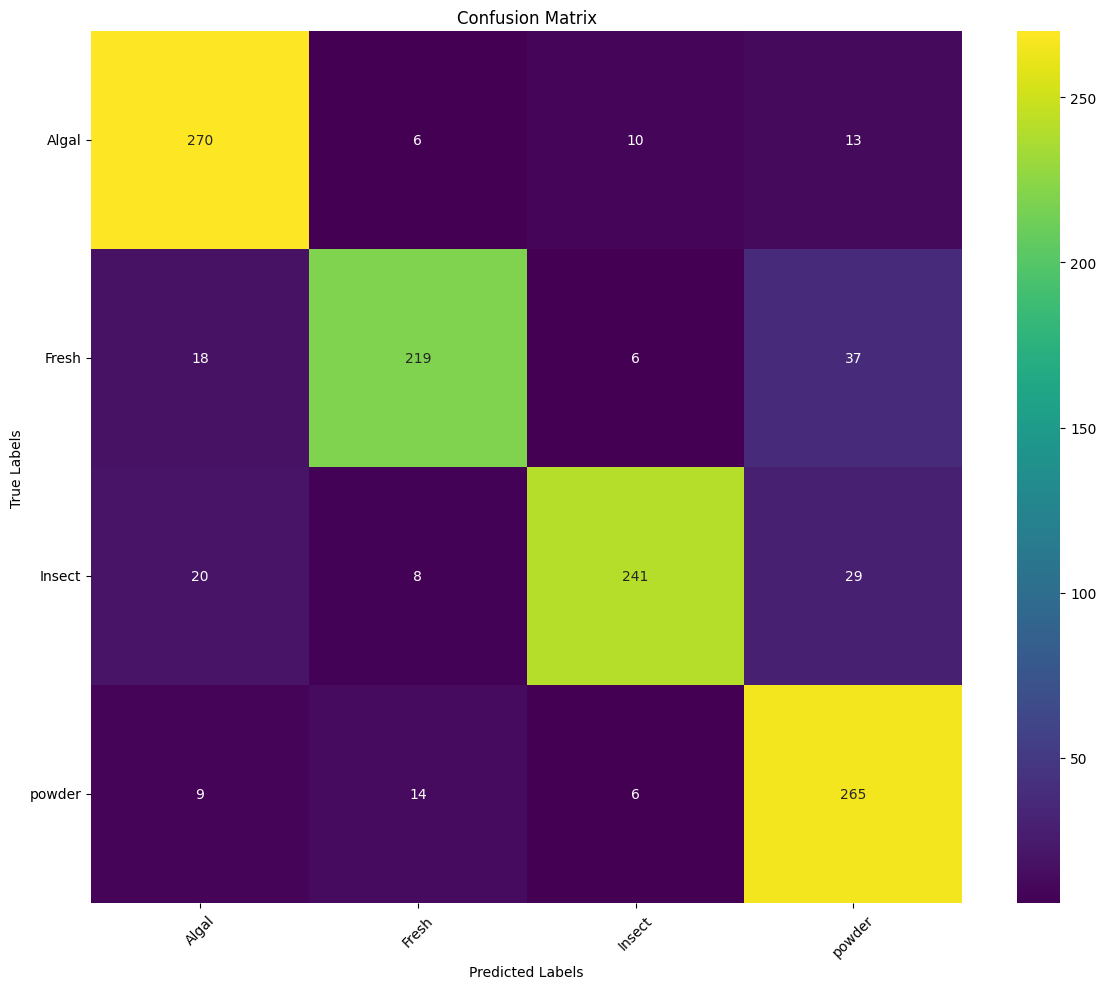

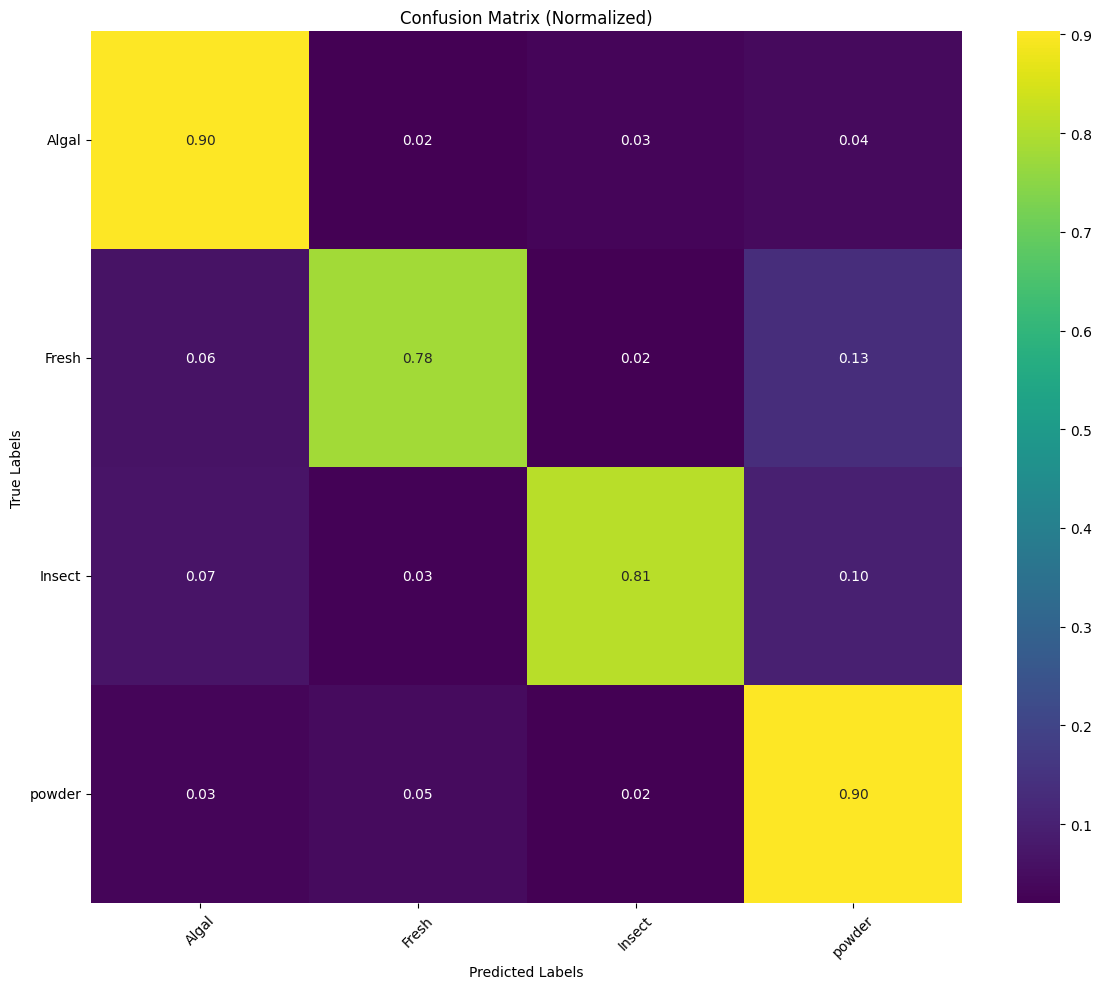

In [ ]:
def draw_confusion_matrix(true, preds, class_names, normalize=None):
    cm = confusion_matrix(true, preds, normalize=normalize)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='viridis',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage
draw_confusion_matrix(y_true, y_pred, class_names=class_names)
draw_confusion_matrix(y_true, y_pred, class_names=class_names, normalize='true')


In [ ]:
model_VGG.save("/content/VGG19_PlantDisease_run2.h5")
model_loaded = tf.keras.models.load_model("/content/VGG19_PlantDisease_run2.h5")


In [ ]:
columns = [
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test'
]


In [ ]:
import pandas as pd

# Evaluate on train, val, and test sets
train_metrics = model_VGG.evaluate(train_generator, verbose=0)
val_metrics = model_VGG.evaluate(valid_generator, verbose=0)
test_metrics = model_VGG.evaluate(test_generator, verbose=0)

# Extract metrics
report_vgg = pd.DataFrame([[
    train_metrics[0], val_metrics[0], test_metrics[0],   # Losses
    train_metrics[1], val_metrics[1], test_metrics[1],   # Accuracies
    train_metrics[2], val_metrics[2], test_metrics[2],   # Precisions
    train_metrics[3], val_metrics[3], test_metrics[3]    # Recalls
]], columns=[
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test'
])

report_vgg


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.392853    0.453459   0.418099        0.858136        0.822926   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.849701         0.884585         0.853236        0.872187   

   Recall Train  Recall Valid  Recall Test  
0       0.82756      0.800684     0.827498

F1 Score and MCC Comparison (Bar Chart)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
plt.bar(x + width/2, mcc_scores, width, label='MCC', color='orange')
plt.xlabel('Dataset')
plt.ylabel('Score')
plt.title('Figure 18: F1 Score and MCC Comparison (VGG19)')
plt.xticks(x, datasets)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


NameError: name 'datasets' is not defined

Accuracy Trend (Line Chart)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(datasets, accuracies, marker='o', linestyle='-', color='green', linewidth=2)
plt.title('Figure 19: Accuracy Trend Across Datasets (VGG19)')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#DenseNet201

In [ ]:
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=inputs)

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(38, activation='softmax')(x)

    model_DenseNet = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_DenseNet.compile(optimizer= optimizer, loss="categorical_crossentropy", metrics=["accuracy",'precision','recall'])

model_DenseNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,664,166 (254.30 MB)

 Trainable params: 48,340,390 (184.40 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

# Define model_checkpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [ ]:
#cell1
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_tensor=inputs)

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Get the number of classes from the train_generator
    num_classes = train_generator.num_classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # Change this line

    model_DenseNet = tf.keras.models.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model_DenseNet.compile(optimizer= optimizer, loss="categorical_crossentropy", metrics=["accuracy",'precision','recall'])

model_DenseNet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,659,780 (254.29 MB)

 Trainable params: 48,336,004 (184.39 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

In [ ]:
history = model_DenseNet.fit(train_generator,
                           epochs = 50,
                           batch_size=32,
                           validation_data = valid_generator,
                           callbacks = callbacks
                           )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 262s 708ms/step - accuracy: 0.5877 - loss: 1.0926 - precision: 0.6375 - recall: 0.5250 - val_accuracy: 0.7314 - val_loss: 0.6975 - val_precision: 0.7560 - val_recall: 0.7023 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 162s 475ms/step - accuracy: 0.7444 - loss: 0.6872 - precision: 0.7824 - recall: 0.7000 - val_accuracy: 0.7887 - val_loss: 0.5512 - val_precision: 0.8132 - val_recall: 0.7562 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 144s 490ms/step - accuracy: 0.7866 - loss: 0.5736 - precision: 0.8166 - recall: 0.7451 - val_accuracy: 0.8272 - val_loss: 0.4580 - val_precision: 0.8537 - val_recall: 0.7990 - learning_rate: 0.0010
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 128s 435ms/step - accuracy: 0.7995 - loss: 0.5296 - precision: 0.8330 - recall: 0.7664 - val_accuracy: 0.8255 - val_loss: 0.4585 - val_precision: 0.8504 - val_recall: 0.7973 - learning_rate: 0.0010
Epoch 5/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 153s 522

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC

# Custom MCC metric
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

# Input shape
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Number of classes from the generator
    num_classes = train_generator.num_classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_DenseNet = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile with extra metrics
    model_DenseNet.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            AUC(name='AUC'),
            matthews_correlation
        ]
    )

# Model summary
model_DenseNet.summary()

# Training
history = model_DenseNet.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=valid_generator,
    callbacks=callbacks
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,659,780 (254.29 MB)

 Trainable params: 48,336,004 (184.39 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 263s 723ms/step - AUC: 0.8291 - accuracy: 0.6058 - loss: 1.0895 - matthews_correlation: 0.4827 - precision: 0.6534 - recall: 0.5537 - val_AUC: 0.9283 - val_accuracy: 0.7545 - val_loss: 0.6775 - val_matthews_correlation: 0.6744 - val_precision: 0.7736 - val_recall: 0.7305 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 139s 474ms/step - AUC: 0.9256 - accuracy: 0.7455 - loss: 0.6671 - matthews_correlation: 0.6653 - precision: 0.7873 - recall: 0.7027 - val_AUC: 0.9504 - val_accuracy: 0.7938 - val_loss: 0.5346 - val_matthews_correlation: 0.7256 - val_precision: 0.8194 - val_recall: 0.7648 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 148s 506ms/step - AUC: 0.9446 - accuracy: 0.7815 - loss: 0.5687 - matthews_correlation: 0.7099 - precision: 0.8136 - recall: 0.7457 - val_AUC: 0.9564 - val_accuracy: 0.8127 - val_loss: 0.4982 - val_matthews_correlation: 0.7516 - val_precision: 0.8379 - val_recall: 0.7827 - learning_rate:

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC

# Custom MCC metric
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

# Input shape
input_shape = (224, 224, 3)

with tf.distribute.get_strategy().scope():
    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.DenseNet201(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    base_model.trainable = False

    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Number of classes from the generator
    num_classes = train_generator.num_classes
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model_DenseNet = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile with extra metrics
    model_DenseNet.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            AUC(name='AUC'),
            matthews_correlation
        ]
    )

# Model summary
model_DenseNet.summary()

# Training
history = model_DenseNet.fit(
    train_generator,
    epochs=50,
    batch_size=32,
    validation_data=valid_generator,
    callbacks=callbacks
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 66,659,780 (254.29 MB)

 Trainable params: 48,336,004 (184.39 MB)

 Non-trainable params: 18,323,776 (69.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 256s 698ms/step - AUC: 0.8257 - accuracy: 0.6004 - loss: 1.0877 - matthews_correlation: 0.4654 - precision: 0.6399 - recall: 0.5406 - val_AUC: 0.9241 - val_accuracy: 0.7399 - val_loss: 0.6872 - val_matthews_correlation: 0.6632 - val_precision: 0.7693 - val_recall: 0.7160 - learning_rate: 0.0010
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 138s 471ms/step - AUC: 0.9174 - accuracy: 0.7277 - loss: 0.7026 - matthews_correlation: 0.6355 - precision: 0.7656 - recall: 0.6788 - val_AUC: 0.9499 - val_accuracy: 0.7981 - val_loss: 0.5406 - val_matthews_correlation: 0.7353 - val_precision: 0.8307 - val_recall: 0.7682 - learning_rate: 0.0010
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 144s 479ms/step - AUC: 0.9406 - accuracy: 0.7870 - loss: 0.5879 - matthews_correlation: 0.7136 - precision: 0.8178 - recall: 0.7473 - val_AUC: 0.9597 - val_accuracy: 0.8204 - val_loss: 0.4732 - val_matthews_correlation: 0.7633 - val_precision: 0.8441 - val_recall: 0.7964 - learning_rate:

37/37 ━━━━━━━━━━━━━━━━━━━━ 52s 870ms/step


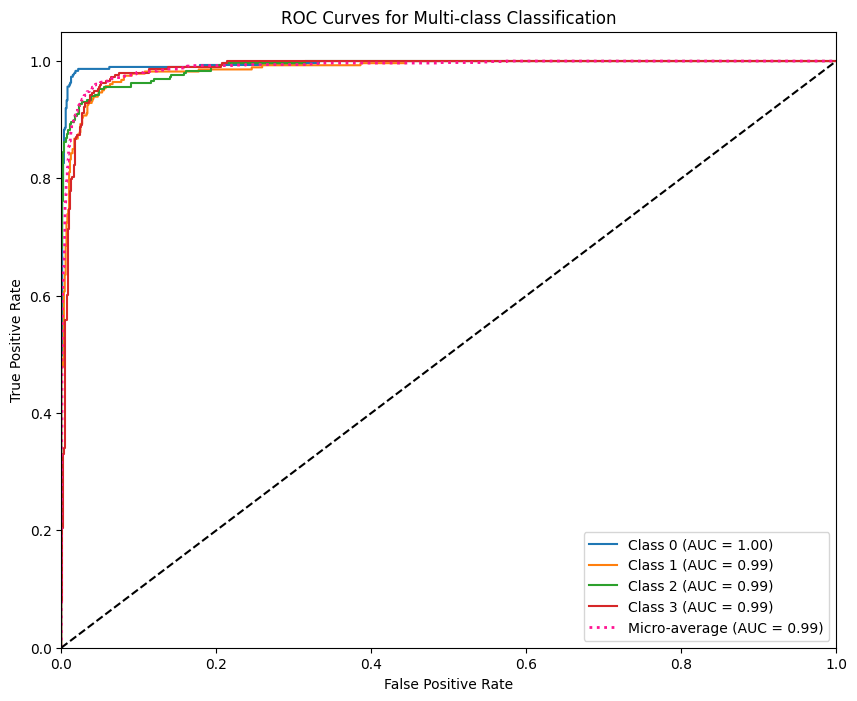

In [ ]:
# prompt: create ROC curve for the dataset

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Get predictions for the test set
predictions = model_DenseNet.predict(test_generator)

# Binarize the labels for multi-class ROC curve
y_true_bin = label_binarize(test_generator.classes, classes=np.arange(train_generator.num_classes))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle=':', linewidth=2, color='deeppink')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd

In [ ]:
# prompt: create classification report with MCC for every class

from sklearn.metrics import matthews_corrcoef

# ... (Your existing code) ...

predictions = model_DenseNet.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Generate classification report with MCC for each class
print("Classification Report with MCC:\n")

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Calculate MCC for each class
mcc_scores = {}
for class_name in class_names:
    mcc = matthews_corrcoef(y_true == test_generator.class_indices[class_name],
                           np.argmax(predictions, axis=1) == test_generator.class_indices[class_name])
    mcc_scores[class_name] = mcc

# Add MCC to the report dataframe
df_report['MCC'] = mcc_scores.values()
df_report


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step
Classification Report with MCC:



ValueError: Length of values (4) does not match length of index (7)

In [ ]:
# prompt: create classification report with MCC for every class

from sklearn.metrics import matthews_corrcoef

# ... (Your existing code) ...

predictions = model_DenseNet.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Generate classification report with MCC for each class
print("Classification Report with MCC:\n")

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Calculate MCC for each class and add to a list
mcc_scores_list = []
for class_name in class_names:
    mcc = matthews_corrcoef(y_true == test_generator.class_indices[class_name],
                           np.argmax(predictions, axis=1) == test_generator.class_indices[class_name])
    mcc_scores_list.append(mcc)

# Add MCC to the report dataframe only for the class rows
df_report.loc[class_names, 'MCC'] = mcc_scores_list

df_report

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
Classification Report with MCC:



precision    recall  f1-score      support       MCC
Algal          0.953947  0.969900  0.961857   299.000000  0.948692
Fresh          0.904255  0.910714  0.907473   280.000000  0.878270
Insect         0.963504  0.885906  0.923077   298.000000  0.899662
powder         0.893891  0.945578  0.919008   294.000000  0.891468
accuracy       0.928266  0.928266  0.928266     0.928266       NaN
macro avg      0.928899  0.928025  0.927854  1171.000000       NaN
weighted avg   0.929419  0.928266  0.928227  1171.000000       NaN

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step


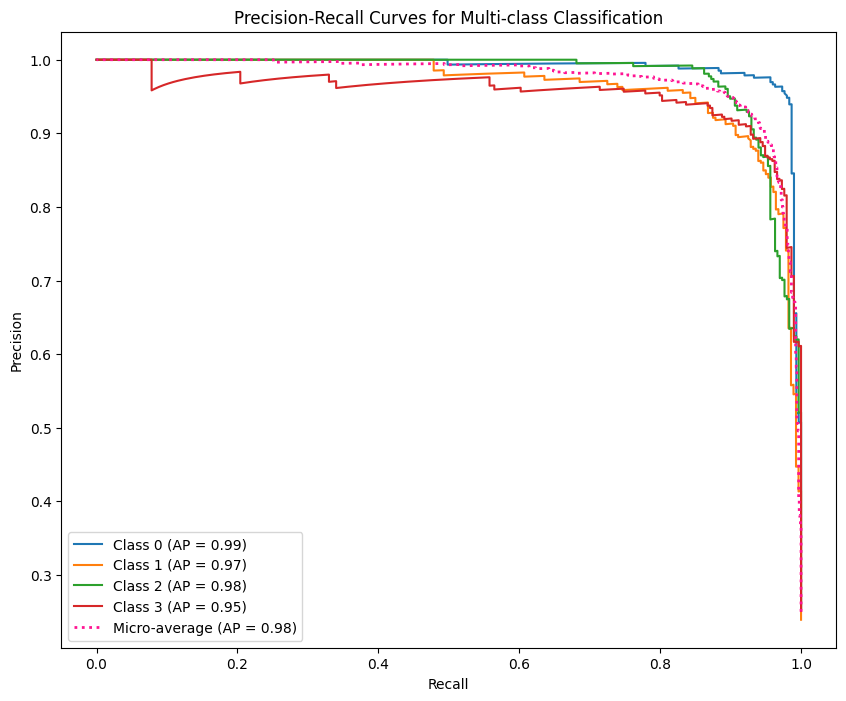

In [ ]:
# prompt: Create PR curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# ... (Your existing code) ...


# Get predictions for the test set
predictions = model_DenseNet.predict(test_generator)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Binarize the labels for multi-class PR curve
y_true_bin = label_binarize(y_true, classes=np.arange(train_generator.num_classes))
n_classes = y_true_bin.shape[1]

# Compute PR curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], predictions[:, i])

# Compute micro-average PR curve and average precision
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(), predictions.ravel()
)
average_precision["micro"] = average_precision_score(y_true_bin, predictions, average="micro")

# Plot PR curves for each class and micro-average
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(
        recall[i],
        precision[i],
        label=f"Class {i} (AP = {average_precision[i]:.2f})",
    )

plt.plot(
    recall["micro"],
    precision["micro"],
    label=f"Micro-average (AP = {average_precision['micro']:.2f})",
    linestyle=":",
    linewidth=2,
    color="deeppink",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Multi-class Classification")
plt.legend(loc="lower left")
plt.show()


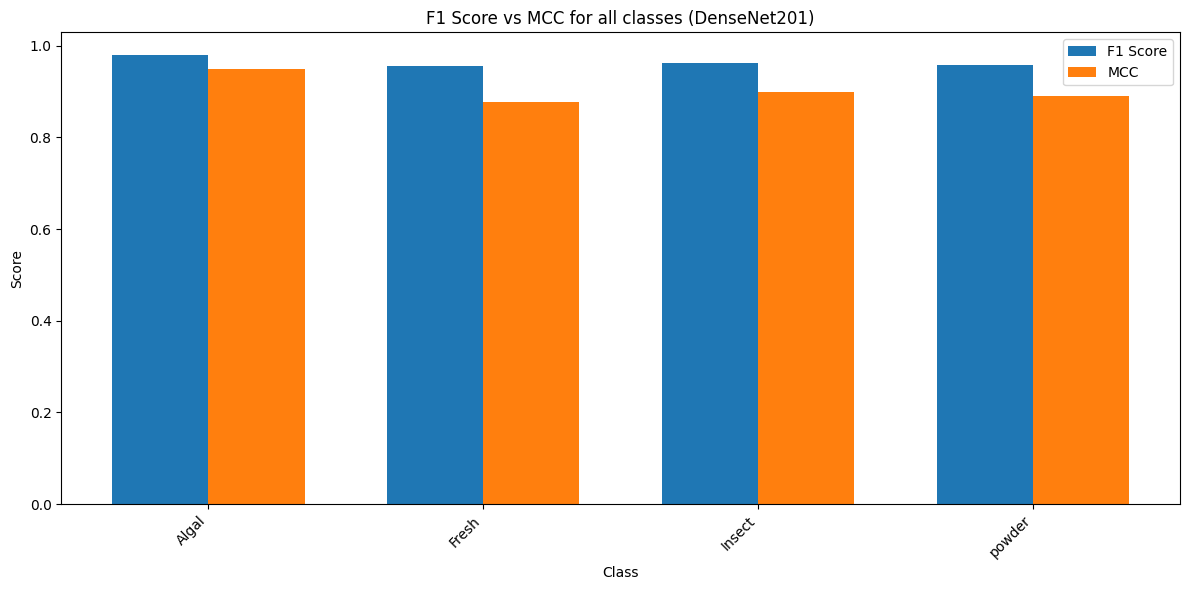

In [ ]:
# prompt: Create F1 score vs MCC Bar chart for all classes

import matplotlib.pyplot as plt

# Assuming you have already calculated f1_scores and mcc_scores for each class
# Example:
# f1_scores = [0.85, 0.92, 0.78, ...]  # F1 scores for each class
# mcc_scores = [0.75, 0.88, 0.65, ...] # MCC scores for each class
# class_names = ['Class 1', 'Class 2', 'Class 3', ...] # Replace with your actual class names

# Calculate F1 scores and MCC scores (replace with your actual calculation)
from sklearn.metrics import f1_score, matthews_corrcoef
f1_scores = []
mcc_scores = []
for i in range(len(class_names)):
    f1 = f1_score(y_true == i, y_pred == i, average="weighted")
    mcc = matthews_corrcoef(y_true == i, y_pred == i)
    f1_scores.append(f1)
    mcc_scores.append(mcc)


x = range(len(class_names))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, f1_scores, width, label='F1 Score')
plt.bar([i + width for i in x], mcc_scores, width, label='MCC')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('F1 Score vs MCC for all classes (DenseNet201)')
plt.xticks([i + width/2 for i in x], class_names, rotation=45, ha='right') # Rotate x-axis labels
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
import pandas as pd

# Evaluate on train, val, and test sets for DenseNet201
train_metrics_dn = model_DenseNet.evaluate(train_generator, verbose=0) # Changed model_DenseNet201 to model_DenseNet
val_metrics_dn = model_DenseNet.evaluate(valid_generator, verbose=0) # Changed model_DenseNet201 to model_DenseNet
test_metrics_dn = model_DenseNet.evaluate(test_generator, verbose=0) # Changed model_DenseNet201 to model_DenseNet

# Metric order: [loss, accuracy, precision, recall, AUC, MCC]
report_densenet201 = pd.DataFrame([[
    train_metrics_dn[0], val_metrics_dn[0], test_metrics_dn[0],   # Losses
    train_metrics_dn[1], val_metrics_dn[1], test_metrics_dn[1],   # Accuracies
    train_metrics_dn[2], val_metrics_dn[2], test_metrics_dn[2],   # Precisions
    train_metrics_dn[3], val_metrics_dn[3], test_metrics_dn[3],   # Recalls
    train_metrics_dn[4], val_metrics_dn[4], test_metrics_dn[4],   # AUCs
    train_metrics_dn[5], val_metrics_dn[5], test_metrics_dn[5]    # MCCs
]], columns=[
    'Loss Train', 'Loss Valid', 'Loss Test',
    'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
    'Precision Train', 'Precision Valid', 'Precision Test',
    'Recall Train', 'Recall Valid', 'Recall Test',
    'AUC Train', 'AUC Valid', 'AUC Test',
    'MCC Train', 'MCC Valid', 'MCC Test'
])

report_densenet201

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.174738    0.253717   0.219542        0.935642        0.913601   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.927412         0.941068         0.917678        0.930975   

   Recall Train  Recall Valid  Recall Test  AUC Train  AUC Valid  AUC Test  \
0      0.928694      0.905903     0.921435   0.994256   0.986806  0.989188   

   MCC Train  MCC Valid  MCC Test  
0   0.913227   0.882119  0.902594

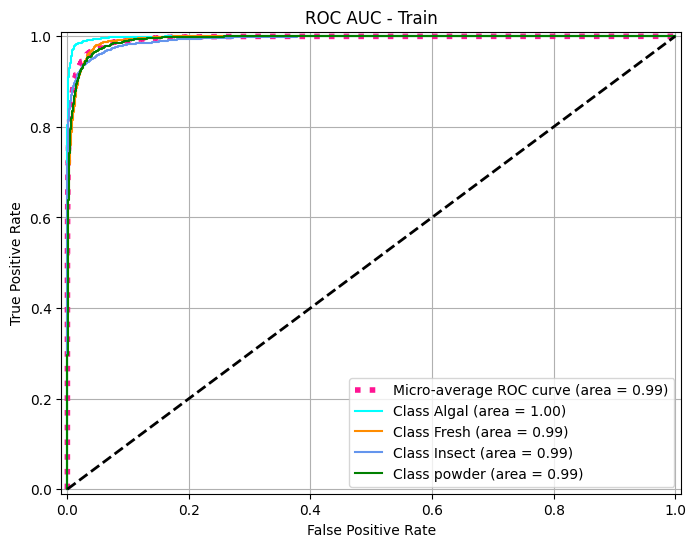

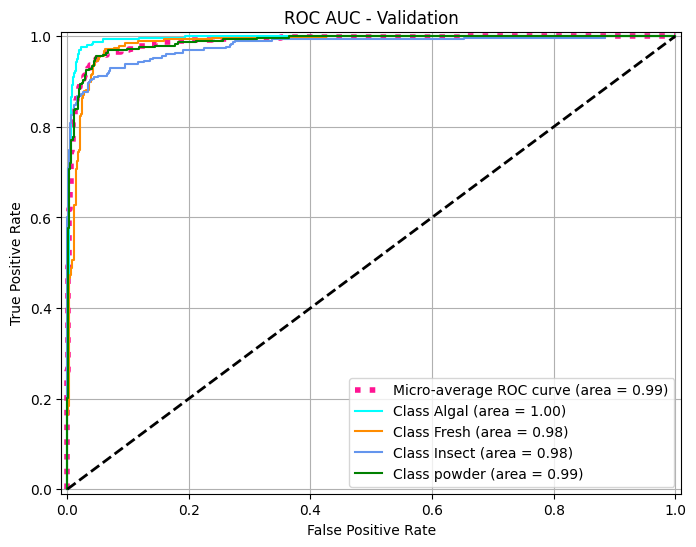

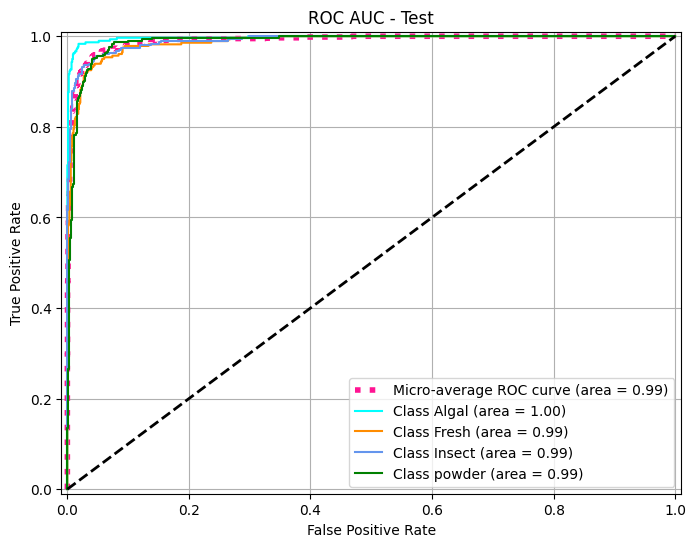

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import itertools

# Get class count
num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())

# Helper: Get true labels and predictions
def get_labels_and_preds(generator, model): # Pass the model as an argument
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x, y = generator[i]
        y_true.append(y)
        y_pred.append(model.predict(x, verbose=0)) # Use the passed model
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

# Helper: Plot ROC AUC
def plot_roc_auc(y_true, y_pred, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC - {title}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot for each dataset
for gen, name in zip([train_generator, valid_generator, test_generator], ['Train', 'Validation', 'Test']):
    y_true, y_pred = get_labels_and_preds(gen, model_DenseNet) # Pass model_DenseNet to the function
    plot_roc_auc(y_true, y_pred, title=name)

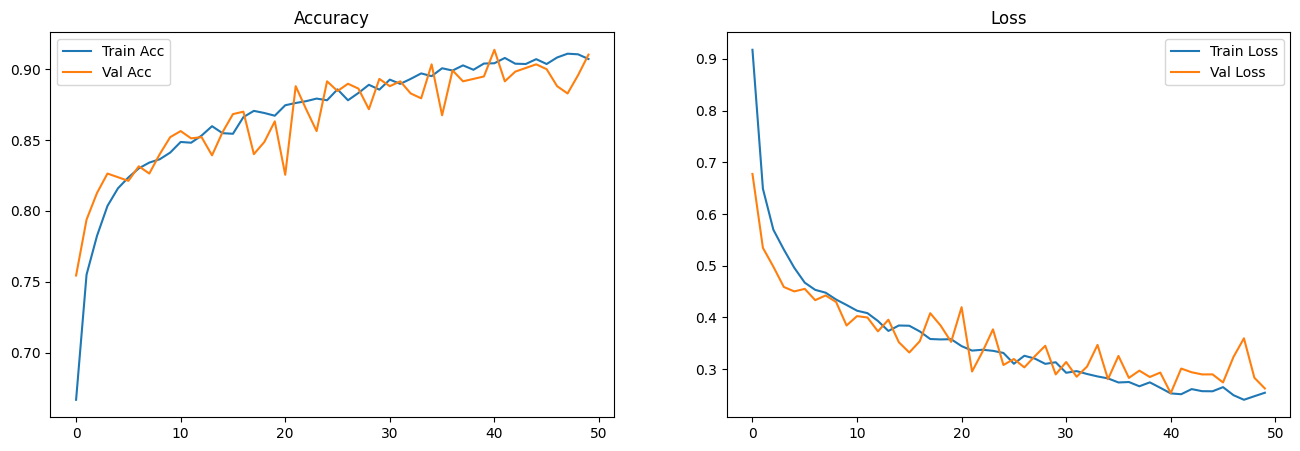

In [ ]:
# Cell 18:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    # Access accuracy using 'accuracy' key, or 'acc' if 'accuracy' is not present
    plt.plot(history.history.get('accuracy', history.history.get('acc', [])), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history) # Pass the history variable to the draw_plots function

In [ ]:
# prompt: save the densenet model and make it download

from google.colab import files
model_DenseNet.save("/content/DenseNet201_PlantDisease_final.h5")
files.download("/content/DenseNet201_PlantDisease_final.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, matthews_corrcoef

# Helper: Get predictions and true labels from a generator
def get_preds_and_labels(generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x, y = generator[i]
        preds = model_VGG.predict(x, verbose=0)
        y_true.append(y)
        y_pred.append(preds)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred

# Helper: Compute F1 and MCC
def compute_metrics(y_true, y_pred):
    y_true_cls = np.argmax(y_true, axis=1)
    y_pred_cls = np.argmax(y_pred, axis=1)
    f1 = f1_score(y_true_cls, y_pred_cls, average='macro')
    mcc = matthews_corrcoef(y_true_cls, y_pred_cls)
    return f1, mcc

# Compute for each set
f1_mcc_results = []
for gen in [train_generator, valid_generator, test_generator]:
    y_true, y_pred = get_preds_and_labels(gen)
    f1, mcc = compute_metrics(y_true, y_pred)
    f1_mcc_results.append((f1, mcc))

# Prepare bar chart
labels = ['Train', 'Validation', 'Test']
f1_scores = [item[0] for item in f1_mcc_results]
mcc_scores = [item[1] for item in f1_mcc_results]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
plt.bar(x + width/2, mcc_scores, width, label='MCC', color='salmon')

plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.title('F1 Score and MCC Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


293/293 ━━━━━━━━━━━━━━━━━━━━ 172s 522ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 18s 485ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step


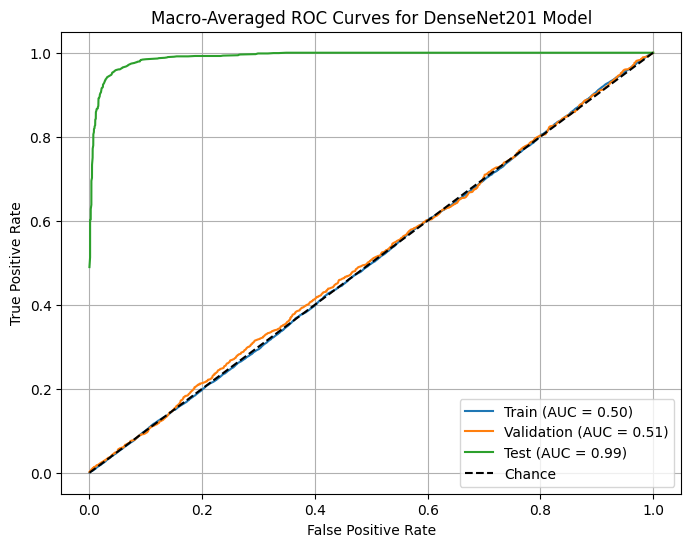

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predicted probabilities
def get_roc_data(generator, dataset_name):
    y_true = generator.classes
    y_true = label_binarize(y_true, classes=range(num_classes))
    y_pred = model_DenseNet.predict(generator)
    return y_true, y_pred, dataset_name

# Collect data
y_train_true, y_train_pred, name_train = get_roc_data(train_generator, "Train")
y_val_true, y_val_pred, name_val = get_roc_data(valid_generator, "Validation")
y_test_true, y_test_pred, name_test = get_roc_data(test_generator, "Test")

# Plot ROC curves
def plot_roc(y_true, y_pred, dataset_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Average/macro AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= num_classes
    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f'{dataset_name} (AUC = {macro_auc:.2f})')

# Plotting all together
plt.figure(figsize=(8, 6))
plot_roc(y_train_true, y_train_pred, name_train)
plot_roc(y_val_true, y_val_pred, name_val)
plot_roc(y_test_true, y_test_pred, name_test)

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curves for DenseNet201 Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Get true labels and predictions
def get_f1_mcc(generator):
    y_true = generator.classes
    y_pred_probs = model_DenseNet201.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute macro F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')

    # Compute MCC (you may already have this from model.evaluate)
    # To recompute:
    from sklearn.metrics import matthews_corrcoef
    mcc = matthews_corrcoef(y_true, y_pred)

    return f1, mcc

# Get F1 and MCC for each split
f1_train, mcc_train = get_f1_mcc(train_generator)
f1_val, mcc_val = get_f1_mcc(valid_generator)
f1_test, mcc_test = get_f1_mcc(test_generator)

# Bar chart data
datasets = ['Train', 'Validation', 'Test']
f1_scores = [f1_train, f1_val, f1_test]
mcc_scores = [mcc_train, mcc_val, mcc_test]

x = np.arange(len(datasets))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
bars2 = ax.bar(x + width/2, mcc_scores, width, label='MCC', color='salmon')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('F1 Score and MCC Comparison (DenseNet201)')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


NameError: name 'model_DenseNet201' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

# Get true labels and predictions
def get_f1_mcc(generator):
    y_true = generator.classes
    y_pred_probs = model_DenseNet201.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Compute macro F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')

    # Compute MCC (you may already have this from model.evaluate)
    # To recompute:
    from sklearn.metrics import matthews_corrcoef
    mcc = matthews_corrcoef(y_true, y_pred)

    return f1, mcc

# Get F1 and MCC for each split
f1_train, mcc_train = get_f1_mcc(train_generator)
f1_val, mcc_val = get_f1_mcc(valid_generator)
f1_test, mcc_test = get_f1_mcc(test_generator)

# Bar chart data
datasets = ['Train', 'Validation', 'Test']
f1_scores = [f1_train, f1_val, f1_test]
mcc_scores = [mcc_train, mcc_val, mcc_test]

x = np.arange(len(datasets))  # label locations
width = 0.35  # bar width

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='skyblue')
bars2 = ax.bar(x + width/2, mcc_scores, width, label='MCC', color='salmon')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('F1 Score and MCC Comparison (DenseNet201)')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


NameError: name 'model_DenseNet201' is not defined

In [ ]:
def Evaluate_model(model, train_generator, valid_generator, test_generator):
    """
    Evaluates a model on the train, validation, and test sets.

    Args:
        model: The Keras model to evaluate.
        train_generator: The data generator for the training set.
        valid_generator: The data generator for the validation set.
        test_generator: The data generator for the test set.

    Returns:
        A list containing the evaluation metrics for the train, validation,
        and test sets, respectively.
    """
    train_metrics = model.evaluate(train_generator, verbose=0)
    val_metrics = model.evaluate(valid_generator, verbose=0)
    test_metrics = model.evaluate(test_generator, verbose=0)

    return [
        train_metrics[0], val_metrics[0], test_metrics[0],  # Losses
        train_metrics[1], val_metrics[1], test_metrics[1],  # Accuracies
        train_metrics[2], val_metrics[2], test_metrics[2],  # Precisions
        train_metrics[3], val_metrics[3], test_metrics[3]   # Recalls
    ]

Report_DenseNet = []
Report_DenseNet.append(Evaluate_model(model_DenseNet, train_generator, valid_generator, test_generator))
Report_DenseNet

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


[[0.17141473293304443,
  0.23088912665843964,
  0.1962110549211502,
  0.940453290939331,
  0.9118905067443848,
  0.9385141134262085,
  0.9438880085945129,
  0.9163071513175964,
  0.9406196475028992,
  0.9369253516197205,
  0.9084687829017639,
  0.9333902597427368]]

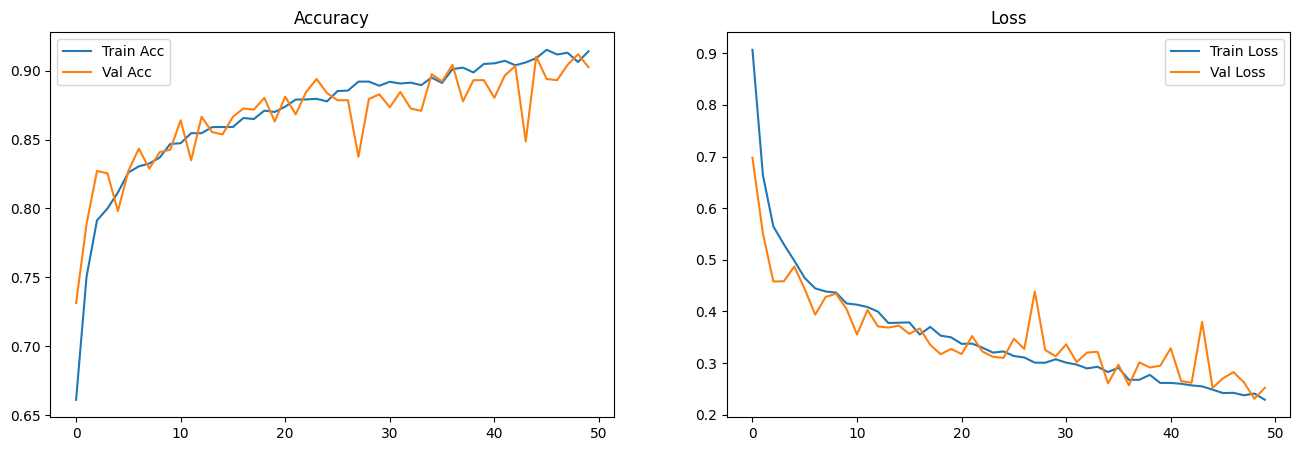

In [ ]:
# Cell 18:
def draw_plots(history):
    plt.figure(figsize=(16, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    # Access accuracy using 'accuracy' key, or 'acc' if 'accuracy' is not present
    plt.plot(history.history.get('accuracy', history.history.get('acc', [])), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', history.history.get('val_acc', [])), label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

draw_plots(history) # Pass the history variable to the draw_plots function

37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 681ms/step
Classification report : 
               precision    recall  f1-score   support

       Algal       0.95      0.97      0.96       299
       Fresh       0.93      0.94      0.94       280
      Insect       0.98      0.88      0.93       298
      powder       0.90      0.96      0.93       294

    accuracy                           0.94      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.94      0.94      0.94      1171

Confusion matrix : 



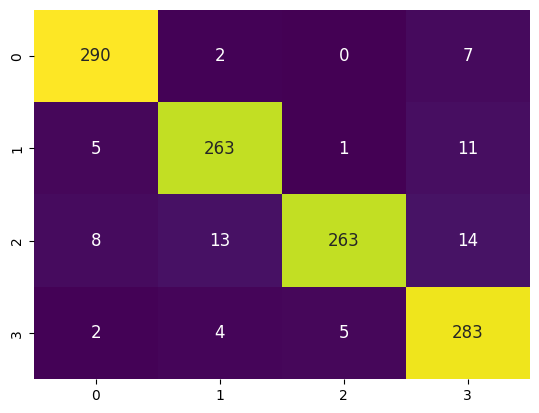

Normalized confusion matrix : 



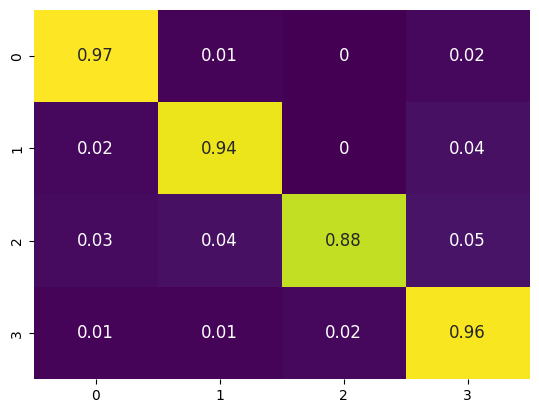

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model_DenseNet.predict(test_generator)

y_pred = predictions.argmax(axis=-1)

class_names = list(test_generator.class_indices.keys())

print("Classification report : \n",classification_report(test_generator.labels, y_pred, target_names = class_names))

def draw_confusion_matrix(true, preds, normalize=None):
    conf_matx = confusion_matrix(true, preds, normalize = normalize)
    conf_matx = np.round(conf_matx, 2)

    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, "true")

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step
Classification report : 
               precision    recall  f1-score   support

       Algal       0.95      0.97      0.96       299
       Fresh       0.93      0.94      0.94       280
      Insect       0.98      0.88      0.93       298
      powder       0.90      0.96      0.93       294

    accuracy                           0.94      1171
   macro avg       0.94      0.94      0.94      1171
weighted avg       0.94      0.94      0.94      1171

Confusion matrix : 



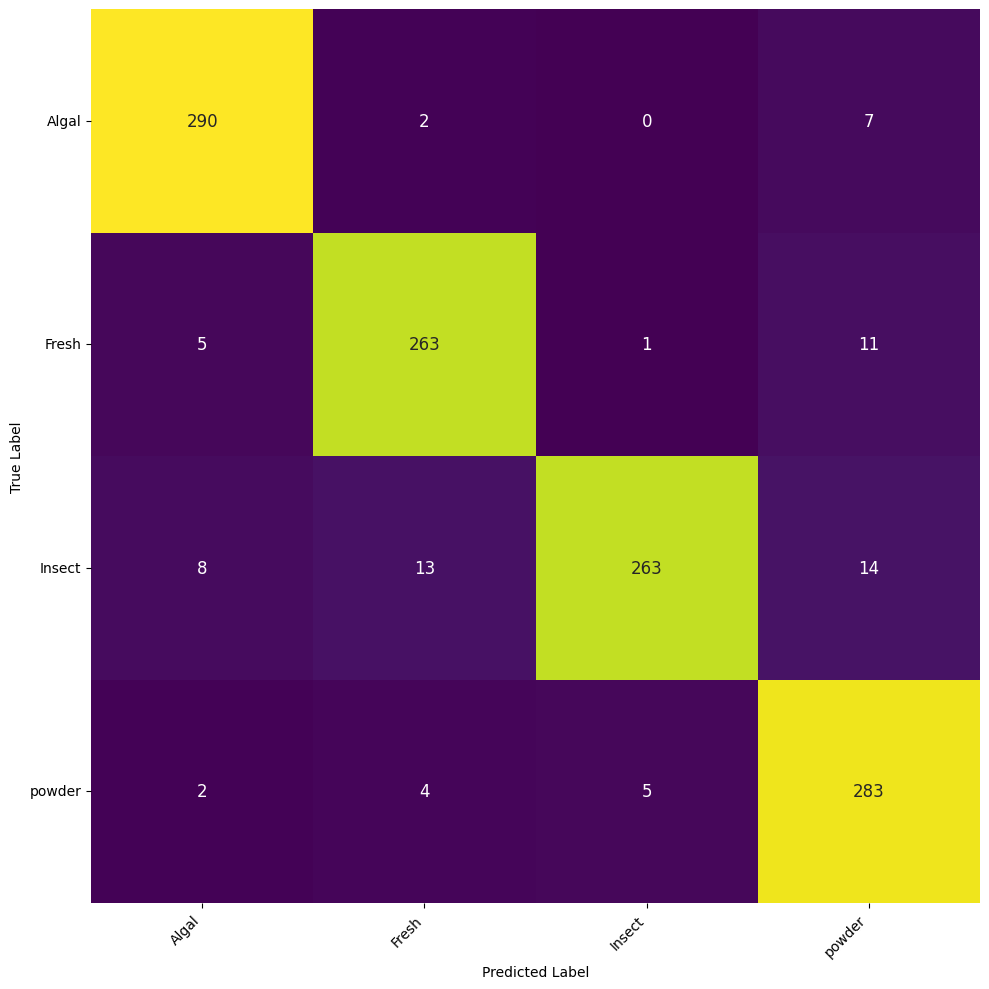

Normalized confusion matrix : 



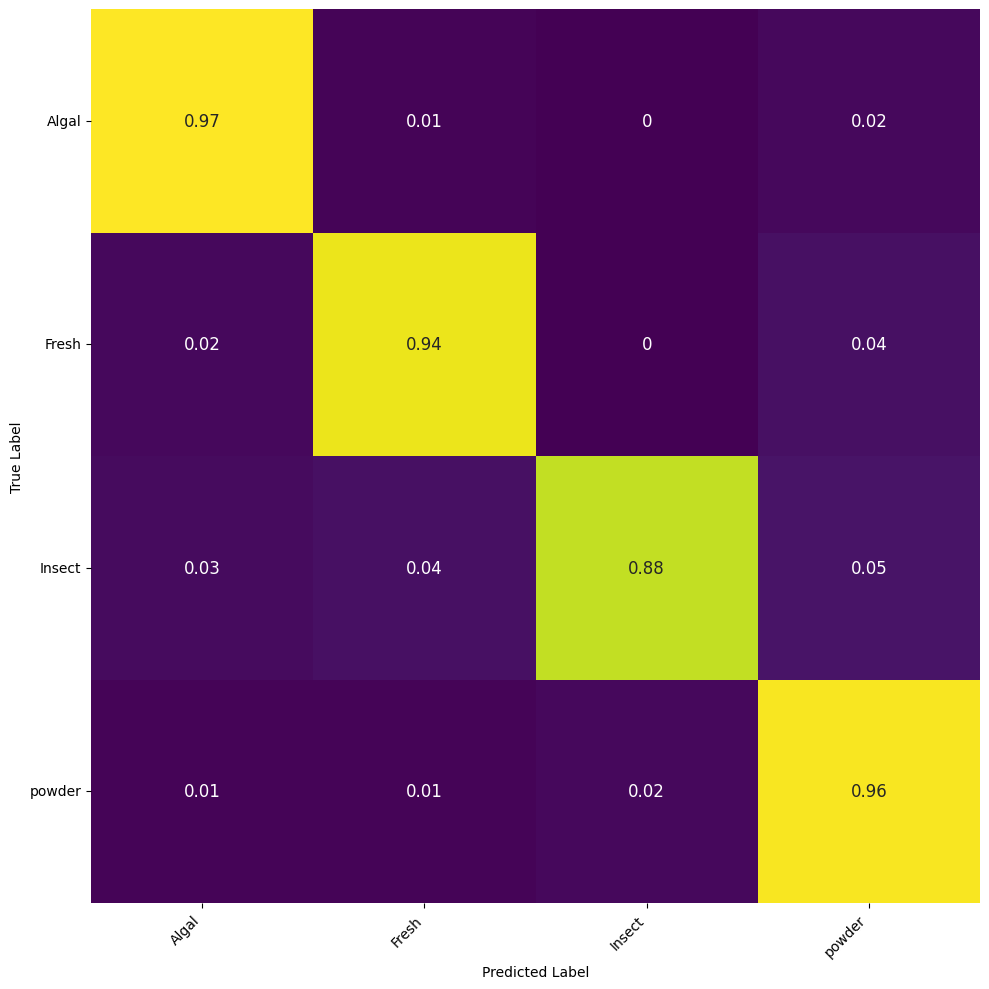

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions = model_DenseNet.predict(test_generator)
y_pred = predictions.argmax(axis=-1)
class_names = list(test_generator.class_indices.keys())

print("Classification report : \n", classification_report(test_generator.labels, y_pred, target_names=class_names))

def draw_confusion_matrix(true, preds, class_names, normalize=None):
    conf_matx = confusion_matrix(true, preds, normalize=normalize)
    conf_matx = np.round(conf_matx, 2)

    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figsize if needed
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12}, fmt="g", cbar=False, cmap="viridis",
                xticklabels=class_names, yticklabels=class_names, ax=ax)  # Add labels
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, class_names)  # Pass class_names

print("Normalized confusion matrix : \n")
draw_confusion_matrix(test_generator.labels, y_pred, class_names, normalize="true")  # Pass class_names

In [ ]:
import pandas as pd # Import the pandas library with the alias

In [ ]:
# Define column names
columns = ['Loss Train', 'Loss Valid', 'Loss Test',
           'Accuracy Train', 'Accuracy Valid', 'Accuracy Test',
           'Precision Train', 'Precision Valid', 'Precision Test',
           'Recall Train', 'Recall Valid', 'Recall Test']

# Convert Report_DenseNet to DataFrame
df_densenet = pd.DataFrame(Report_DenseNet, columns=columns)

# Display the DataFrame
print("Performance Metrics Table for DenseNet201 Model")
display(df_densenet)


Performance Metrics Table for DenseNet201 Model


Loss Train  Loss Valid  Loss Test  Accuracy Train  Accuracy Valid  \
0    0.171415    0.230889   0.196211        0.940453        0.911891   

   Accuracy Test  Precision Train  Precision Valid  Precision Test  \
0       0.938514         0.943888         0.916307         0.94062   

   Recall Train  Recall Valid  Recall Test  
0      0.936925      0.908469      0.93339

In [ ]:
# Define test directory
test_dir = os.path.join(base_dir, "test") # Assuming 'test' is your test data folder

# Create test dataset
test_dataset_vgg = datasets.ImageFolder(root=test_dir, transform=val_transform_vgg)

# Create test data loader
test_loader_vgg = DataLoader(test_dataset_vgg, batch_size=32, shuffle=False, num_workers=2)

NameError: name 'datasets' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


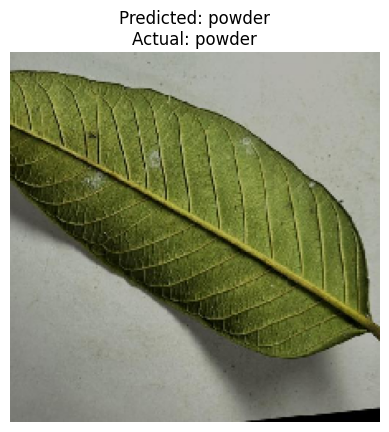

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


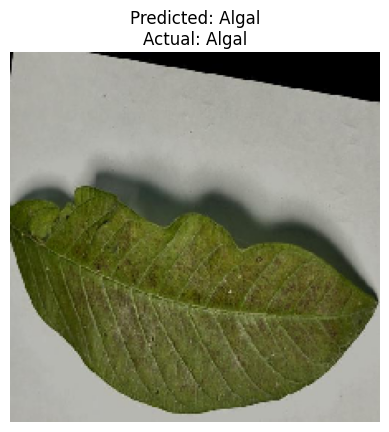

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


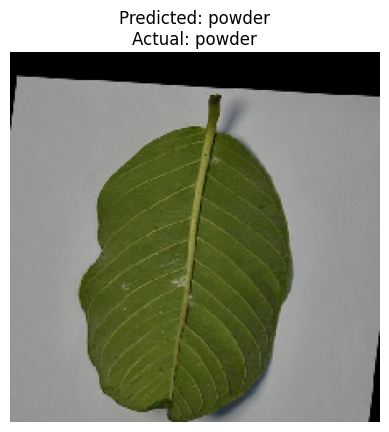

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


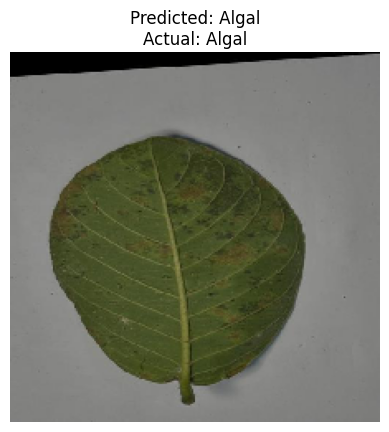

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


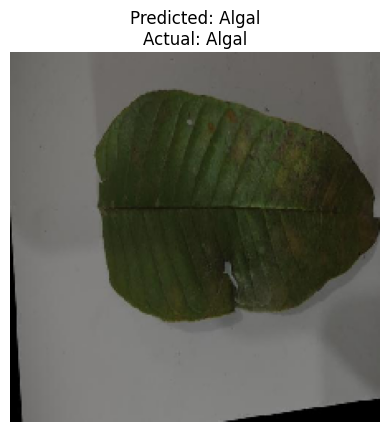

In [ ]:
# prompt: make the densenet model do prediction on test data by selecting them randomly and showing predicted label and actual label. show the images and predicted laben and actual label

import random
import matplotlib.pyplot as plt

# Assuming test_generator and class_names are defined from the previous code

# Get a random set of indices from the test set
num_samples_to_display = 5  # Adjust the number of samples to display
random_indices = random.sample(range(len(test_generator.filenames)), num_samples_to_display)

for i in random_indices:
    # Predict the label for the image at the current index
    image, label = test_generator[i // BATCH_SIZE][0][i % BATCH_SIZE], test_generator[i // BATCH_SIZE][1][i % BATCH_SIZE]
    prediction = model_DenseNet.predict(np.expand_dims(image, axis=0))
    predicted_label_index = np.argmax(prediction)
    predicted_label = class_names[predicted_label_index]
    actual_label = class_names[np.argmax(label)]

    # Display the image, predicted, and actual labels
    plt.figure()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_718']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


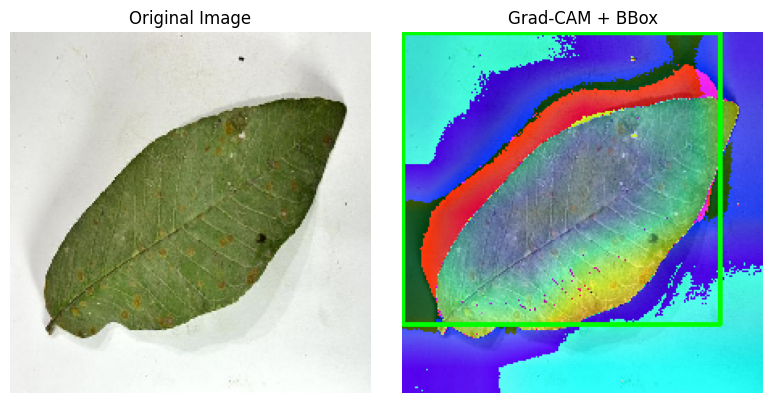

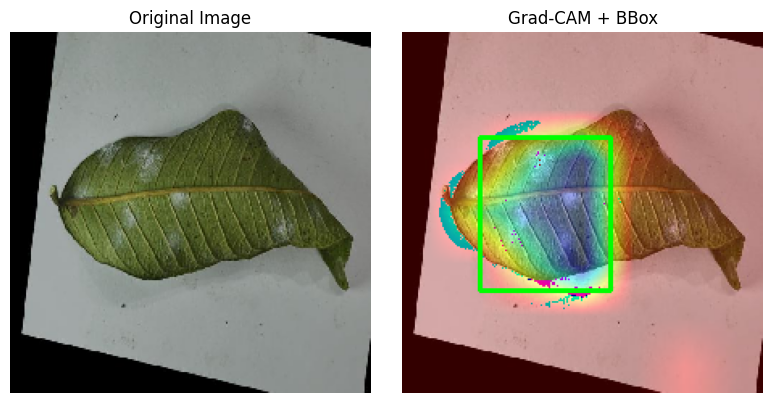

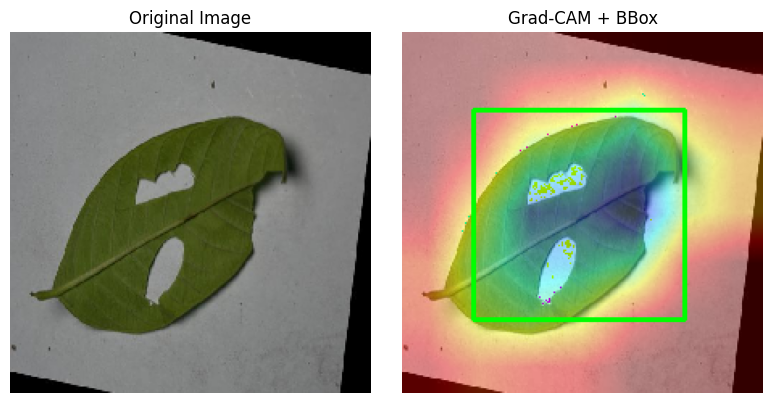

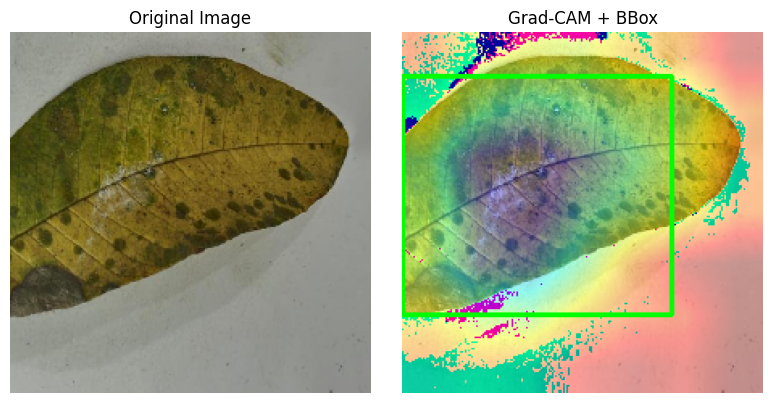

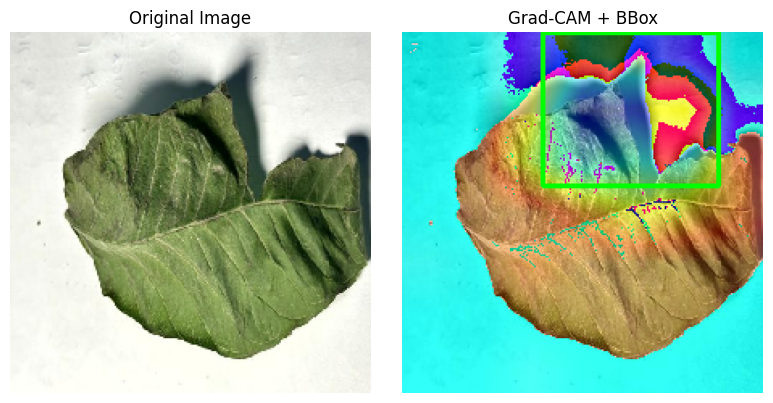

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam_with_bboxes(original_img, heatmap, threshold=0.5, alpha=0.4):
    # Resize and normalize heatmap
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_normalized = np.uint8(255 * heatmap_resized)

    # Apply color map
    heatmap_color = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = heatmap_color * alpha + original_img
    superimposed_img = np.uint8(superimposed_img)

    # Threshold and find contours
    _, binary_map = cv2.threshold(heatmap_normalized, int(threshold * 255), 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    boxed_img = superimposed_img.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(boxed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return boxed_img

# Visualize Grad-CAM with bounding boxes on random test samples
num_samples = 5
random_indices = random.sample(range(len(test_generator.filenames)), num_samples)

for i in random_indices:
    img_path = test_generator.filepaths[i]
    original_pil = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    original_img = tf.keras.preprocessing.image.img_to_array(original_pil)
    img_array = np.expand_dims(original_img, axis=0) / 255.0

    heatmap = make_gradcam_heatmap(img_array, model_DenseNet, last_conv_layer_name="conv5_block32_concat")
    gradcam_boxed = display_gradcam_with_bboxes(np.uint8(original_img), heatmap)

    # Show results
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_pil)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(gradcam_boxed)
    plt.title("Grad-CAM + BBox")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
pip install ultralytics scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!pip install ultralytics  # Install ultralytics package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!gdown --id 1Ri_UwseiVcmhR8U1bu2g_0jOnYvG2gyp

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ri_UwseiVcmhR8U1bu2g_0jOnYvG2gyp
From (redirected): https://drive.google.com/uc?id=1Ri_UwseiVcmhR8U1bu2g_0jOnYvG2gyp&confirm=t&uuid=62f06e77-0e56-423d-9a94-6d279c6a4f1e
To: /content/New folder.zip
100% 296M/296M [00:04<00:00, 64.1MB/s]


In [ ]:
!unzip '/content/New folder.zip' -d '/content/New folder'

Streaming output truncated to the last 5000 lines.
  inflating: /content/New folder/New folder/val/Algal/augmented_4_93_1972.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_93_1973.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_93_1974.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_94_1978.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_95_1980.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_95_1982.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_95_1983.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_96_1986.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_96_1987.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_97_1988.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_97_1991.JPG  
  inflating: /content/New folder/New folder/val/Algal/augmented_4_98_

In [ ]:
from ultralytics import YOLO  # works for YOLOv8
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
import torch
import numpy as np

# Load model
model = YOLO('/content/best1200.pt')  # Replace with path if different

# Run predictions on test dataset
results = model.val()  # This will evaluate using validation set from config

# To evaluate on your own test set:
# results = model.eval(data='path/to/data.yaml', split='test')

# Extract metrics
precision = results.box.metrics.precision  # e.g. results.box.map50
recall = results.box.metrics.recall
mAP50 = results.box.map50
mAP5095 = results.box.map
loss = results.box.loss

# If you want raw predictions to calculate AUC, MCC manually:
preds = []
targets = []

for pred in results:
    preds.extend(pred.probs.cpu().numpy())  # Probabilities
    targets.extend(pred.cls.cpu().numpy())  # Ground truth

# Convert to numpy
preds = np.array(preds)
targets = np.array(targets)

# Threshold if needed
pred_labels = (preds > 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(targets, pred_labels)
auc = roc_auc_score(targets, preds)
mcc = matthews_corrcoef(targets, pred_labels)

# Print results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"mAP@0.5: {mAP50:.4f}")
print(f"mAP@0.5:0.95: {mAP5095:.4f}")


Ultralytics 8.3.127 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n-cls summary (fused): 47 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/New folder/New folder/train... found 6000 images in 4 classes ✅ 
val: /content/New folder/New folder/val... found 6000 images in 4 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 615.7±280.4 MB/s, size: 15.3 KB)


val: Scanning /content/New folder/New folder/val... 6000 images, 0 corrupt: 100%|██████████| 6000/6000 [00:01<00:00, 4058.48it/s]


val: New cache created: /content/New folder/New folder/val.cache


               classes   top1_acc   top5_acc:   0%|          | 1/375 [00:02<16:59,  2.73s/it]


100%|██████████| 755k/755k [00:00<00:00, 20.7MB/s]
               classes   top1_acc   top5_acc:  18%|█▊        | 67/375 [02:52<13:12,  2.57s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input


In [ ]:
model = load_model('/content/DenseNet201_PlantDisease_final.h5')


OSError: Unable to synchronously open file (truncated file: eof = 348127232, sblock->base_addr = 0, stored_eof = 655553080)

In [ ]:
img_size = (224, 224)
batch_size = 32

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(
    '/content/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(val_generator.class_indices.keys())
n_classes = len(class_names)
